In [1]:
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse(r'C:\Users\cid2r\Downloads\db\discogs_20220201_masters.xml')
#tree = ET.parse('rel.xml')
root = tree.getroot()

In [ ]:
pip install python3-discogs-client

In [3]:
import discogs_client

d = discogs_client.Client('ExampleApplication/0.1', user_token = 'WkcTWMWNFmwUFYHrtQIreHRnLmyFZTNnkflNHsgc')


In [2]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/"
win_dir = r"D:\AlbumCover"


print(win_dir)

D:\AlbumCover


In [ ]:
#0310추가
import requests
import shutil
#0312추가
import requests
from bs4 import BeautifulSoup
import json



for release in root.iter('master'):
    id = release.attrib.get('id')
    
    if int(id) > 70630:


        master_scarp = 'https://www.discogs.com/master/' + str(id)
        soup = BeautifulSoup(requests.get(master_scarp).text)
        rslt = soup.find('script', attrs={'id':'master_schema'})
        if rslt == None:
            rating = 0
        else:
            json_file = json.loads(rslt.get_text())
            rating = json_file['@graph'][0]['aggregateRating']['ratingCount']
            
        standard = 1000 if 'Electronic' in literal_eval(str(json_file['@graph'][0]['genre'])) else 500 if ('Rock' in literal_eval(str(json_file['@graph'][0]['genre']))) else 150
    
        if rating >= standard:
            
            print(id)
    
            gens=[]
            for gen in release.iter('genre'):
               gens.append(gen.text)
    
            imglnk = d.master(id).images
            if(imglnk != None):
                if('uri150' in imglnk[0]):
                    uri = imglnk[0]['uri150']
    
        
            if len(gens) == 1:
                if gens[0] == 'Funk / Soul':
                    gens[0] = 'Funk&Soul'
                makedirs(macos_dir+gens[0])
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, ('Funk&Soul' if gens[0] == 'Funk / Soul' else gens[0]), img_name)
                #0310add
                makedirs(os.path.join(win_dir, gens[0]))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
            else:
                multi_dir = ''
                separator = '+'
                for idx, val in enumerate(gens):
                    multi_dir += ('Funk&Soul' if val == 'Funk / Soul' else val) + ('' if idx == len(gens) -1 else separator)
                img_name = id + '.jpeg'
                img_dir = os.path.join(win_dir, 'multi', multi_dir, img_name)
            
                makedirs(os.path.join(win_dir, 'multi',multi_dir))
                r = requests.get(uri, stream=True, headers={'User Agent' : 'Mozilla/5.0'})
                if r.status_code == 200:
                    with open(img_dir, 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
            
            

    
        if(int(id) >= 74999):
            break

print("done! done!")



In [20]:
import os

#win
#db_list = os.listdir(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\data")

#mac
db_list = os.listdir(r"/Users/cooky/Documents/GitHub/0220dbtest/data")

In [33]:
list = ['a', 'b', 'c']
for idx, val in enumerate(list):
    print(idx)
    print(('' if val == 'b' else 'd'))
    print('----')

0
d
----
1

----
2
d
----


In [1]:
cd data

/Users/cooky/Documents/GitHub/0220dbtest/data


In [17]:
import pandas as pd



alldata = []

for file in db_list:
    df = pd.read_csv(file)
    alldata.append(df)

df_0_2_100k = pd.concat(alldata, axis=0, ignore_index=True)
df_0_2_100k.to_csv("/Users/cooky/Documents/GitHub/0220dbtest/data/output", index=False)




NameError: name 'db_list' is not defined

In [40]:
df_0_2_100k = pd.read_csv("data_20k_2_25k.csv")

In [85]:
df_0_2_100k

,Unnamed: 0,id,genre,styles,uri
0,0,5000,"['Electronic', 'Rock']","['Goth Rock', 'Darkwave']",https://i.discogs.com/T7z4VGjIsJ10lIHFEbfJr0oB...
1,1,5001,['Rock'],['Alternative Rock'],https://i.discogs.com/l7hDj9vk7vHlv8sKX1E-vw8p...
2,2,5002,['Electronic'],"['EBM', 'Electro']",https://i.discogs.com/ACNm3X583wKVev9rUuTv4KKa...
3,3,5003,['Electronic'],"['Hardcore', 'Gabber']",https://i.discogs.com/-z1t-N_BcSiUY_O99ajwQLvu...
4,4,5004,"['Rock', 'Pop']","['Acoustic', 'Power Pop', 'Indie Rock']",https://i.discogs.com/V3YsXD8TvQ82Lop3pWNppDbF...
...,...,...,...,...,...
95844,4783,54996,['Rock'],"['Pop Rock', 'Ballad']",https://i.discogs.com/rD1D4B5z1moxwfRgs9Nnvip7...
95845,4784,54997,['Electronic'],"['New Wave', 'Synth-pop']",https://i.discogs.com/eJWhpBN7vZSd59fTK4ytrw-8...
95846,4785,54998,['Rock'],['Alternative Rock'],https://i.discogs.com/jdva2LpfMic2Tvjs1IC9qKn0...
95847,4786,54999,"['Rock', 'Pop']",['Pop Rock'],https://i.discogs.com/B7fkPNUmu7Hrx8H1-zZz8BLE...


In [41]:
df_test = df_0_2_100k.copy()

In [100]:
df_test.drop(columns='Unnamed: 0')

,id,genre,styles,uri,Electronic,Rock,Pop,Hip Hop,Classical,Jazz,Stage & Screen,Reggae,"Folk, World, & Country",Funk / Soul,Blues,Latin,Non-Music,Children's,Brass & Military
0,5000,"['Electronic', 'Rock']","['Goth Rock', 'Darkwave']",https://i.discogs.com/T7z4VGjIsJ10lIHFEbfJr0oB...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5001,['Rock'],['Alternative Rock'],https://i.discogs.com/l7hDj9vk7vHlv8sKX1E-vw8p...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5002,['Electronic'],"['EBM', 'Electro']",https://i.discogs.com/ACNm3X583wKVev9rUuTv4KKa...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5003,['Electronic'],"['Hardcore', 'Gabber']",https://i.discogs.com/-z1t-N_BcSiUY_O99ajwQLvu...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5004,"['Rock', 'Pop']","['Acoustic', 'Power Pop', 'Indie Rock']",https://i.discogs.com/V3YsXD8TvQ82Lop3pWNppDbF...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95844,54996,['Rock'],"['Pop Rock', 'Ballad']",https://i.discogs.com/rD1D4B5z1moxwfRgs9Nnvip7...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
95845,54997,['Electronic'],"['New Wave', 'Synth-pop']",https://i.discogs.com/eJWhpBN7vZSd59fTK4ytrw-8...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95846,54998,['Rock'],['Alternative Rock'],https://i.discogs.com/jdva2LpfMic2Tvjs1IC9qKn0...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
95847,54999,"['Rock', 'Pop']",['Pop Rock'],https://i.discogs.com/B7fkPNUmu7Hrx8H1-zZz8BLE...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
from ast import literal_eval


for idx,row in df_test.iterrows():
    gen_str = row['genre']
    gens = literal_eval(gen_str)
    #print(idx)
    for gen in gens:
        if gen in df_test.columns:
            df_test.at[idx, gen] = 1
        else:
            df_test[gen] = 0
            df_test.at[idx, gen] = 1

            

            

In [ ]:

print(df_test)

In [101]:
pd.crosstab(df_test.Jazz, df_test.Electronic)

Electronic,0,1
Jazz,,
0,33727,58569
1,2726,827


In [2]:
import os
import urllib.request
from ast import literal_eval

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise


macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/"

In [25]:
import urllib.request
from ast import literal_eval

In [42]:
macos_dir = "/Users/cooky/Documents/GitHub/0220dbtest/"

for idx, row in df_test.iterrows():
    
    gen_str = row['genre']
    gens = literal_eval(gen_str)

    if len(gens) == 1:
        makedirs(macos_dir+gens[0])
        uri150 = row['uri']
        print(uri150)
        img_name = row['id']
        print(img_name)
        urllib.request.urlretrieve(uri150, img_name)
        
        



https://i.discogs.com/lAZl_5o8nOm_RjSpGXb6rx4A5O59Tm2zEgwbkq-Khf8/rs:fit/g:sm/q:40/h:150/w:150/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTQ4NTU4/MS0xNjQ0NTMwOTk5/LTUwNTYuanBlZw.jpeg
20000


HTTPError: HTTP Error 403: Forbidden

In [20]:
from pandas import DataFrame

df.to_csv(r'C:\Users\cid2r\Documents\!VSCode\0220dbtest\df.csv')

In [41]:
DISCOGS_KEY = 'OKxXReJmUJvMJRRsaOqr'
DISCOGS_SECRET = 'RormADbxpiujDCXDiBDwFGUFxKrVjkTK'

In [ ]:
from bs4 import BeautifulSoup
import re
import urllib.request
from urllib.request import urlopen
import pandas as pd

url = open(r"C:\Users\cid2r\Documents\!VSCode\0220dbtest\rel.xml")

soup = BeautifulSoup(url, "html.parser")


data = {'id' : [], 'genre' : []}


for release in soup.select('release'):
    data['id'].append(release['id'])
    for gen in release.select('genre'):
        data['genre'].append(gen)

asdf = pd.DataFrame(data)

print(data)

#print(asdf)


In [18]:
import requests
from bs4 import BeautifulSoup
import json


master_no = 6832

master_scarp = 'https://www.discogs.com/master/' + str(master_no)

soup = BeautifulSoup(requests.get(master_scarp).text)

rslt = soup.find('script', attrs={'id':'master_schema'})


json_file = json.loads(rslt.get_text())


array = literal_eval(str(json_file['@graph'][0]['genre']))

for i in array:
    print(i)

#rating = json_file['@graph'][0]['aggregateRating']['ratingCount']

#if rating > 10:
    #print('yes')


Electronic


In [1]:
#win
#pip install fastai

#mac
conda install -c fastai fastai

SyntaxError: invalid syntax (722898775.py, line 5)

In [2]:
from fastai.vision.all import *

BATCH_SIZE = 64



In [1]:
data = ImageDataLoaders.from_folder(path=win_dir, valid_pct=0.2, seed=42, item_tfms=RandomResizedCrop(128, min_scale=0.35))


NameError: name 'ImageDataLoaders' is not defined

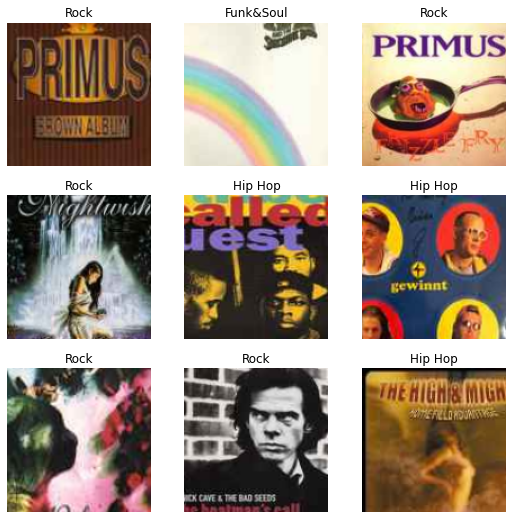

In [17]:
data.show_batch()

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

AttributeError: 'Sequential' object has no attribute 'plot'

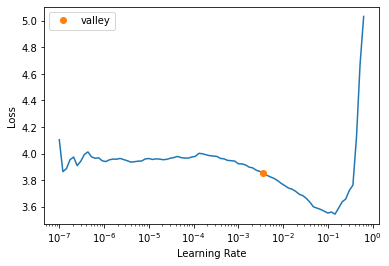

In [19]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))